In [20]:
import pandas as pd
import numpy as np
from KalmanFilter import KalmanFilter

## 1 - Load dataset Yolov5l

In [21]:
detect_Yolov5l_df = pd.read_csv('ADL-Rundle-6\\det\\Yolov5l\\det.txt', sep = ' ', names = ["frame", "id", "bb_left", "bb_top", "bb_width",
"bb_height", "conf", "x", "y", "z"])

In [22]:
detect_Yolov5l_df.head()

,frame,id,bb_left,bb_top,bb_width,bb_height,conf,x,y,z
0,1,-1,1700,391,156,337,0.914550,-1,-1,-1
1,1,-1,250,456,107,248,0.883148,-1,-1,-1
2,1,-1,1255,539,60,118,0.826354,-1,-1,-1
3,1,-1,1288,459,73,199,0.745969,-1,-1,-1
4,1,-1,120,504,93,239,0.740778,-1,-1,-1


In [23]:
detect_Yolov5l_df.drop(columns=["x", "y", "z"], inplace=True)

In [24]:
detect_Yolov5l_df.dtypes

frame          int64
id             int64
bb_left        int64
bb_top         int64
bb_width       int64
bb_height      int64
conf         float64
dtype: object

## Clean the dataframe
To clean it we will get rid of NaN and all the conf bellow 0.5.

## 2 - Create similarity matrix

### Define the lists or arrays to store the current tracked bounding boxes and the new detections for the current frame.

In [25]:
bounding_boxes = detect_Yolov5l_df.groupby("frame")

In [26]:
bounding_boxes.first()

,id,bb_left,bb_top,bb_width,bb_height,conf
frame,,,,,,
1,-1,1700,391,156,337,0.914550
2,-1,1689,390,163,338,0.900352
3,-1,1686,389,163,340,0.908388
4,-1,1684,390,162,341,0.894863
5,-1,1686,389,159,344,0.909074
...,...,...,...,...,...,...
521,-1,695,284,219,586,0.873641
522,-1,695,294,250,580,0.873710
523,-1,691,296,274,577,0.923026


# Use the kalman Filter

In [27]:
kalman_params = {
    "dt": 0.1,
    "u_x": 0,
    "u_y": 0,
    "std_acc": 1,
    "x_sdt_meas": 0.1,
    "y_sdt_meas": 0.1
}

class Track:
    def __init__(self, track_id, bb_left, bb_top, bb_width, bb_height, conf, kalman_params):
        self.id = track_id
        self.bb = [bb_left, bb_top, bb_width, bb_height]
        self.bb_left = bb_left
        self.bb_top = bb_top
        self.bb_width = bb_width
        self.bb_height = bb_height
        self.conf = conf
        self.missed_frames = 0

        # Initialize the Kalman Filter
        self.kf = KalmanFilter(**kalman_params)

        # Compute the initial centroid to set the Kalman filter state
        cx = self.bb_left + self.bb_width / 2.0
        cy = self.bb_top + self.bb_height / 2.0
        # Assuming state vector: [cx, cy, vx, vy]^T
        self.kf.x_k = np.array([[cx],
                                [cy],
                                [0],   # initial vx
                                [0]],  # initial vy
                                dtype=float)

    def predict(self):
        predicted_state, _ = self.kf.predict()
        cx, cy = predicted_state[0, 0], predicted_state[1, 0]

        # Update bounding box using predicted centroid, keep width & height unchanged
        self.bb_left = cx - (self.bb_width / 2.0)
        self.bb_top = cy - (self.bb_height / 2.0)
        self.bb[0] = self.bb_left
        self.bb[1] = self.bb_top
        self.bb[2] = self.bb_width
        self.bb[3] = self.bb_height

    def update(self, bb_left, bb_top, bb_width, bb_height, conf):
        """
        Update the track with a new bounding box measurement and confidence.

        Parameters:
            bb_left (float): Left coordinate of the detected bounding box.
            bb_top (float): Top coordinate of the detected bounding box.
            bb_width (float): Width of the detected bounding box.
            bb_height (float): Height of the detected bounding box.
            conf (float): Detection confidence.
        """
        # Compute centroid of the detected bounding box
        cx = bb_left + bb_width / 2.0
        cy = bb_top + bb_height / 2.0
        z_k = np.array([[cx], [cy]], dtype=float)

        # Update the Kalman filter with the new measurement
        self.kf.update(z_k)

        # Retrieve the updated state from the Kalman filter
        cx_est = self.kf.x_k[0, 0]
        cy_est = self.kf.x_k[1, 0]

        # Update the track's bounding box with the estimated centroid
        self.bb_left = cx_est - (bb_width / 2.0)
        self.bb_top = cy_est - (bb_height / 2.0)
        self.bb_width = bb_width
        self.bb_height = bb_height
        
        self.bb[0] = self.bb_left
        self.bb[1] = self.bb_top
        self.bb[2] = self.bb_width
        self.bb[3] = self.bb_height
        
        self.conf = conf

        # Reset missed frames since we got a match
        self.missed_frames = 0



In [28]:
def process_detections_by_frame(detections_df):
    grouped_detections = (
        detections_df.groupby('frame')[['id', 'bb_left', 'bb_top', 'bb_width', 'bb_height', 'conf']]
        .apply(lambda x: x.values.tolist())
    )
    detections_with_missing_frames = []
    
    # Add 0 for missing frames
    
    for frame_detections in grouped_detections:
        track_object = [Track(detection[0], detection[1], detection[2], detection[3], detection[4], detection[5], kalman_params) for detection in frame_detections]
        detections_with_missing_frames.append(track_object)
    
    return detections_with_missing_frames


detections_by_frame = process_detections_by_frame(detect_Yolov5l_df)

print("Detections by Frame:", detections_by_frame)

Detections by Frame: [[<__main__.Track object at 0x000001D25FE8F380>, <__main__.Track object at 0x000001D24BFE6C00>, <__main__.Track object at 0x000001D24C2C2DB0>, <__main__.Track object at 0x000001D24C2C2870>, <__main__.Track object at 0x000001D24C1B5280>, <__main__.Track object at 0x000001D25FF8AB70>, <__main__.Track object at 0x000001D25FF550A0>], [<__main__.Track object at 0x000001D25FF56A80>, <__main__.Track object at 0x000001D25FF56A50>, <__main__.Track object at 0x000001D26271C6E0>, <__main__.Track object at 0x000001D26271C830>, <__main__.Track object at 0x000001D26271C890>, <__main__.Track object at 0x000001D26271C8F0>, <__main__.Track object at 0x000001D26271C950>], [<__main__.Track object at 0x000001D26271C9B0>, <__main__.Track object at 0x000001D26271CA10>, <__main__.Track object at 0x000001D26271CA70>, <__main__.Track object at 0x000001D26271CAD0>, <__main__.Track object at 0x000001D26271CB30>, <__main__.Track object at 0x000001D26271CB90>, <__main__.Track object at 0x00000

In [29]:
def compute_iou(box1, box2):
    # Convert to corner coordinates
    x1_min, y1_min = box1[0], box1[1]
    x1_max, y1_max = x1_min + box1[2], y1_min + box1[3]

    x2_min, y2_min = box2[0], box2[1]
    x2_max, y2_max = x2_min + box2[2], y2_min + box2[3]

    # Calculate the intersection coordinates
    inter_x_min = max(x1_min, x2_min)
    inter_y_min = max(y1_min, y2_min)
    inter_x_max = min(x1_max, x2_max)
    inter_y_max = min(y1_max, y2_max)

    # Compute intersection area
    inter_width = max(0, inter_x_max - inter_x_min)
    inter_height = max(0, inter_y_max - inter_y_min)
    inter_area = inter_width * inter_height

    # Compute areas of the individual boxes
    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)

    # Compute union area
    union_area = box1_area + box2_area - inter_area

    # Compute IoU
    iou = inter_area / union_area if union_area > 0 else 0

    return iou
    

def create_similarity_matrix(last_frame, current_frame):
    if not last_frame or not current_frame:
        return np.zeros((len(last_frame), len(current_frame)))

    similarity_matrix = np.zeros((len(last_frame), len(current_frame)))

    for i, tracked_box in enumerate(last_frame):
        for j, new_box in enumerate(current_frame):
            # print(tracked_box)
            # print(new_box)
            similarity_matrix[i, j] = compute_iou(tracked_box.bb, new_box.bb)

    return similarity_matrix

In [30]:
from scipy.optimize import linear_sum_assignment

def get_mapping_boxes(similarity_matrix, threshold=0.2):

    cost_matrix = 1 - similarity_matrix
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    mappings = []
    
    for r, c in zip(row_ind, col_ind):
        similarity = similarity_matrix[r, c]
        if similarity > threshold:
            mappings.append((r, c, similarity))
    
    return mappings

# Get the similar boxes to keep the id

In [31]:
similarity_matrix = create_similarity_matrix(detections_by_frame[0], detections_by_frame[1])

mapping = get_mapping_boxes(similarity_matrix)

print("Mapping of old boxes to new boxes with maximum similarity:")
for old_box, new_box, similarity in mapping:
    print(f"Old box {old_box} -> New box {new_box} (similarity: {similarity})")


Mapping of old boxes to new boxes with maximum similarity:
Old box 0 -> New box 0 (similarity: 0.9075511144183409)
Old box 1 -> New box 1 (similarity: 0.8733689205219455)
Old box 2 -> New box 2 (similarity: 0.9354838709677419)
Old box 3 -> New box 4 (similarity: 0.9365661505025809)
Old box 4 -> New box 5 (similarity: 0.8691294514169142)
Old box 5 -> New box 3 (similarity: 0.9593191758444433)
Old box 6 -> New box 6 (similarity: 0.9228761581625995)


## Ploting similarity matrix between frame 1 and 2

In [32]:
import matplotlib.pyplot as plt

def plot_similarity_matrix(similarity_matrix, frame_idx):
    """
    Plot the similarity matrix for a given frame.

    Parameters:
        similarity_matrix: 2D numpy array of IoU values.
        frame_idx: Index of the current frame for labeling purposes.
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(similarity_matrix, cmap='viridis', interpolation='nearest')
    plt.colorbar(label='IoU')
    plt.title(f"Similarity Matrix for Frame {frame_idx}")
    plt.xlabel("New Detections")
    plt.ylabel("Tracked Objects")
    plt.xticks(range(similarity_matrix.shape[1]), [f"Detection {i}" for i in range(similarity_matrix.shape[1])])
    plt.yticks(range(similarity_matrix.shape[0]), [f"Tracked {i}" for i in range(similarity_matrix.shape[0])])
    plt.show()


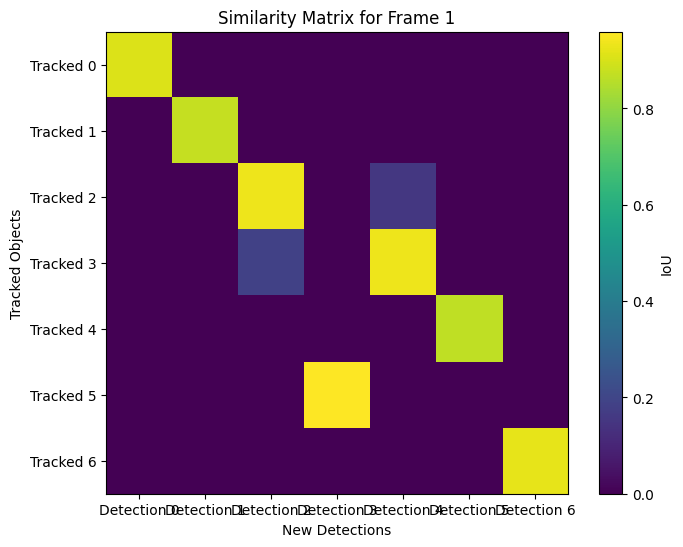

In [33]:
plot_similarity_matrix(similarity_matrix, 1)

In [34]:
def snapshot_tracks(tracks):
    frame_snapshot = []
    for trk in tracks:
        onframe = (trk.missed_frames == 0)
        frame_snapshot.append((
            trk.id,
            trk.bb_left,
            trk.bb_top,
            trk.bb_width,
            trk.bb_height,
            trk.conf,
            onframe
        ))
    return frame_snapshot

In [35]:
def store_bbx_id(detections_by_frame, number_of_missing_frame=60):
    
    
    if detections_by_frame is None or len(detections_by_frame) == 0:
        print("No detection in the frames")
        return None
    
    id_counter = 0
    frame = detections_by_frame[0]
    for i in range(len(frame)):
        frame[i].id = id_counter
        frame[i].predict()
        
        id_counter += 1
    
    current_tracks = frame
    
    all_tracked_frames = [snapshot_tracks(current_tracks)]

    
    for i in range(1, len(detections_by_frame)):
        
        new_detections = detections_by_frame[i]
        
        similarity_matrix = create_similarity_matrix(current_tracks, new_detections)
        mapping = get_mapping_boxes(similarity_matrix)
        # plot_similarity_matrix(similarity_matrix, i)
    
        matched_tracks = set()
        matched_detections = set()


        for old_t_idx, new_d_idx, _ in mapping:
            matched_tracks.add(old_t_idx)
            matched_detections.add(new_d_idx)
            
            det = new_detections[new_d_idx]
            current_tracks[old_t_idx].update(det.bb_left, det.bb_top, det.bb_width, det.bb_height, det.conf)
            current_tracks[old_t_idx].predict()

        unmatched_tracks = set(range(len(current_tracks))) - matched_tracks
        for unmatch in unmatched_tracks:
            current_tracks[unmatch].missed_frames += 1
            current_tracks[unmatch].predict()

        current_tracks = [t for t in current_tracks if t.missed_frames <= number_of_missing_frame]


        unmatched_detections = set(range(len(new_detections))) - matched_detections
        for ud in unmatched_detections:
            det = new_detections[ud]
            det.id = id_counter
            id_counter += 1
            
            det.predict()  # predict once for initialization
            current_tracks.append(det)

        
        all_tracked_frames.append(snapshot_tracks(current_tracks))
        
    return all_tracked_frames
            

In [36]:
current_tracked = store_bbx_id(detections_by_frame=detections_by_frame)

In [37]:
current_tracked

[[(0, np.float64(1700.0), np.float64(391.0), 156.0, 337.0, 0.91455, True),
  (1, np.float64(250.0), np.float64(456.0), 107.0, 248.0, 0.883148, True),
  (2, np.float64(1255.0), np.float64(539.0), 60.0, 118.0, 0.826354, True),
  (3, np.float64(1288.0), np.float64(459.0), 73.0, 199.0, 0.745969, True),
  (4, np.float64(120.0), np.float64(504.0), 93.0, 239.0, 0.740778, True),
  (5, np.float64(0.0), np.float64(243.0), 110.0, 666.0, 0.655897, True),
  (6, np.float64(1885.0), np.float64(369.0), 35.0, 213.0, 0.489681, True)],
 [(0,
   np.float64(1688.999632361952),
   np.float64(389.9999754907968),
   163.0,
   338.0,
   0.900352,
   True),
  (1,
   np.float64(262.0003186196417),
   np.float64(456.00004901840646),
   96.0,
   250.0,
   0.875928,
   True),
  (2,
   np.float64(1257.0000735276094),
   np.float64(538.0),
   59.0,
   120.0,
   0.823182,
   True),
  (3,
   np.float64(1291.000098036813),
   np.float64(461.00004901840646),
   71.0,
   197.0,
   0.732246,
   True),
  (4,
   np.float64(1

# 5 - Save video

In [38]:
import os
import cv2

def display_and_save_tracking_from_images(image_folder, tracked_data, output_video_path):
    """
    Display image sequence with overlaid bounding boxes and save the tracking results as a video.
    
    Parameters:
        image_folder (str): Path to the folder containing image sequence.
        tracked_data (list): List of tracked bounding boxes for each frame.
        output_video_path (str): Path to save the output video.
    """
    # Get sorted list of image files
    image_files = sorted([os.path.join(image_folder, img) for img in os.listdir(image_folder) if img.endswith(('.jpg'))])
    if not image_files:
        print("Error: No images found in the folder.")
        return
    
    # Read the first image to get frame dimensions
    first_image = cv2.imread(image_files[0])
    frame_height, frame_width = first_image.shape[:2]
    fps = 10  # Assuming a default FPS for the output video

    # Define codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Use 'XVID' for .avi files
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))
    
    # Iterate through image files and overlay bounding boxes
    for frame_idx, image_path in enumerate(image_files):
        frame = cv2.imread(image_path)
        if frame_idx >= len(tracked_data):
            break
        
        # Get the bounding boxes for the current frame
        current_frame_boxes = tracked_data[frame_idx]
        
        # Draw bounding boxes and IDs on the frame
        for box in current_frame_boxes:
            track_id, x, y, w, h, conf, onframe = box
            if not onframe:
                continue
            # Draw rectangle
            cv2.rectangle(frame, (int(x), int(y)), (int(x + w), int(y + h)), (0, 255, 0), 2)
            # Add track ID label
            cv2.putText(frame, f"ID: {track_id}       conf: {conf:.2f}", (int(x), int(y - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
        
        # Write frame to output video
        out.write(frame)
        
        # Display the frame
        cv2.imshow('Tracking', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    # Release video resources
    out.release()
    cv2.destroyAllWindows()

# Example usage
image_folder = "ADL-Rundle-6\\img1"
output_video_path = "tracked_output_video.mp4"
display_and_save_tracking_from_images(image_folder, current_tracked, output_video_path)


## 6 - Save into file

In [40]:
def save_tracking_results_txt_images(tracked_data, image_folder, output_dir):
    """
    Save tracking results to a text file in the required format for an image sequence.
    
    Parameters:
        tracked_data (list): List of tracked bounding boxes for each frame.
        image_folder (str): Path to the folder containing image sequence.
        output_dir (str): Directory to save the tracking results.
    """
    sequence_name = os.path.basename(os.path.normpath(image_folder))
    output_file = os.path.join(output_dir, f"{sequence_name}.txt")
    
    with open(output_file, 'w') as file:
        for frame_idx, frame_data in enumerate(tracked_data):
            for box in frame_data:
                track_id, x, y, w, h, conf, _ = box
                file.write(f"{frame_idx + 1},{track_id},{x},{y},{w},{h},{conf},1,-1,-1,-1\n")
    
    print(f"Tracking results saved to {output_file}")


output_dir = "tracking_results"
os.makedirs(output_dir, exist_ok=True)
save_tracking_results_txt_images(current_tracked, image_folder, output_dir)

Tracking results saved to tracking_results\img1.txt
